# Knowledge Base Classification

## Load imports.

In [3]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import requests

from loader import load_preprocessed_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from kb_classifier import KnowledgeBaseClassifier
from kb_common import wiki_topics_to_actual_topics

## Load the data.

In [5]:
x, y = load_preprocessed_data('data/rcv1_kb.csv')
x = np.array(x)
y = np.array(y)

# Get 20% test
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = x[split_point:]
test_y = y[split_point:]

# Take N documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=120)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 20:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

print(counts)

86079
[20. 20. 20. 20. 20. 20.]


## Initialise and tune class probabilities for unsupervised learner

In [6]:
np.random.seed(42)
kb_predictor = KnowledgeBaseClassifier(topic_code_to_topic_dict.values(), topic_depth=1)
kb_predictor.train(train_x, train_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
Wiki topic probabilies shape: (120, 299)


In [7]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
Wiki topic probabilies shape: (120, 299)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000        20
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000        20
             ELECTIONS   1.000000  1.000000  1.000000        20
                HEALTH   1.000000  1.000000  1.000000        20
              RELIGION   1.000000  1.000000  1.000000        20
                SPORTS   1.000000  1.000000  1.000000        20

             micro avg   1.000000  1.000000  1.000000       120
             macro avg   1.000000  1.000000  1.000000       120
          w

## Some Data Exploration

Look at mean topic probabilities for each class.

[0.05264166 0.09883045 0.08980513 0.04723149 0.03006774 0.03997349]


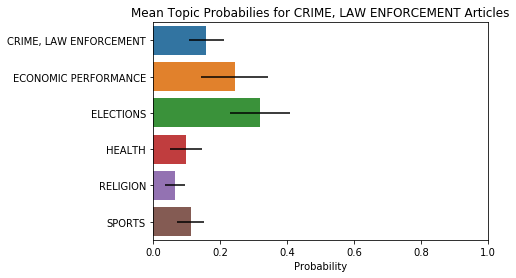

[0.01318815 0.08930956 0.05088608 0.03140952 0.02959951 0.04728976]


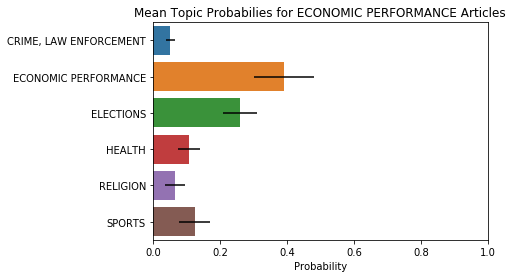

[0.02767979 0.08109091 0.09892902 0.02593959 0.01375418 0.04071204]


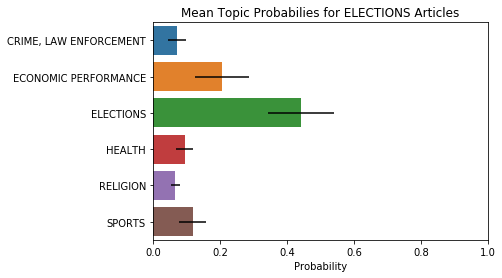

[0.01594394 0.06131391 0.08107575 0.12238867 0.01567126 0.03065613]


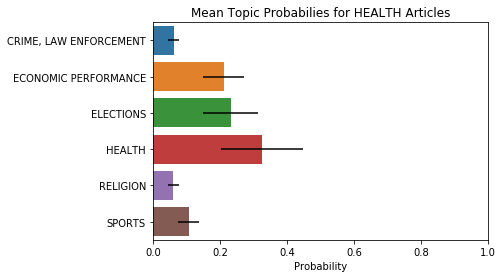

[0.01317044 0.0603021  0.067206   0.03425206 0.05703507 0.03610976]


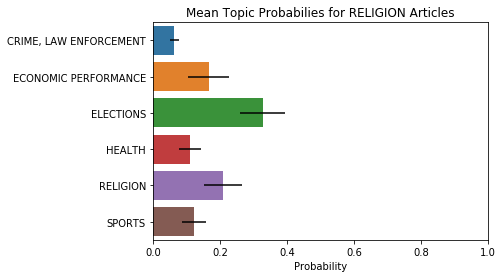

[0.02520175 0.0577617  0.06174743 0.02726171 0.03592272 0.15490149]


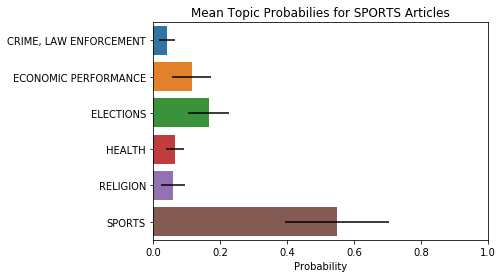

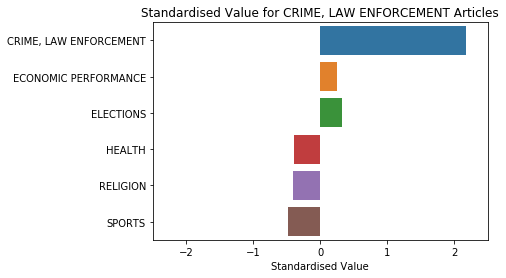

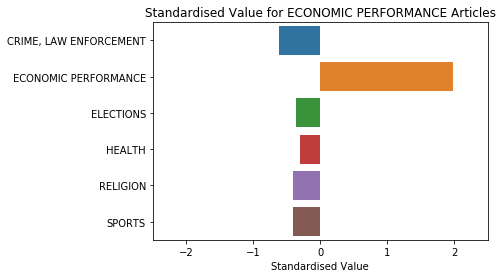

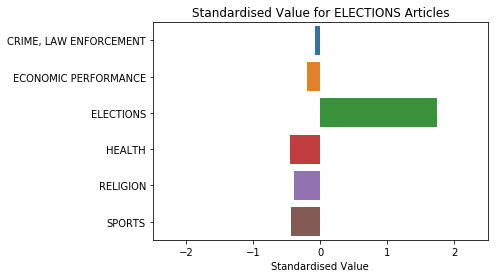

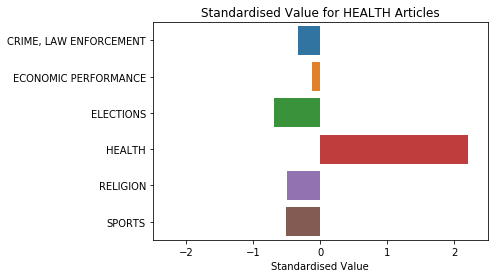

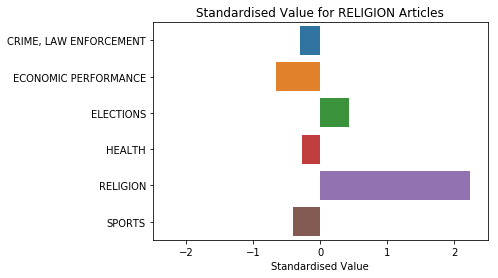

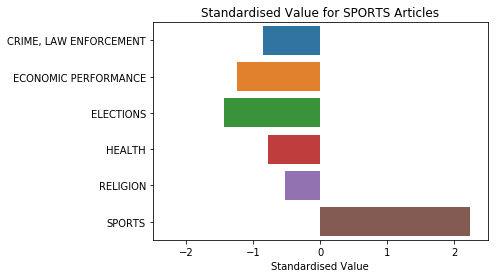

In [8]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    print(prob_std)
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 1.0)
    sns.barplot(x=prob_mean, y=list(topic_code_to_topic_dict.values()), xerr=prob_std)
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(topic_code_to_topic_dict.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

## Assess unsupervised classifier performance.

In [ ]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

## Find examples where predictions went wrong

In [ ]:
for topic_code, index in topic_code_to_int.items():
    topic_subset = predict_y[test_y == index]
    topic_subset_incorrect = topic_subset[topic_subset != index]
    document_subset = test_x[test_y == index]
    document_subset = document_subset[topic_subset != index]
    
    print('------ 5 random erroneous predictions for {} ------'.format(topic_code_to_topic_dict[topic_code]))
    print('')
    random_indices = np.random.choice(np.arange(len(topic_subset_incorrect)), 5)
    for index in random_indices:
        print(document_subset[index])
        print('')
        print('Above classified as {}'.format(topic_code_to_topic_dict[int_to_topic_code[topic_subset_incorrect[index]]]))
        print('')
    print('')